# General Sparse Constraints

ParOpt now supports general sparse constraints. This new feature is still being developed, but will eventually work in parallel in the same manner as the Jacobian-free sparse constraints in earlier versions of ParOpt. For now these constraints must be for serial problems only.

The following example illustrates the use of sparse constraints on a simple problem. This is the electron problem from the COPS optimization problem set.

To use the sparse constraints, the problem class must still inherit from ``ParOpt.Problem``, but requires different initializer options. 

```python
    # The super class initialization
    super(Electron, self).__init__(
        self.comm,
        nvars=self.nvars,
        num_sparse_constraints=self.num_sparse_constraints,
        num_sparse_inequalities=0,
        rowp=rowp,
        cols=cols,
    )
```

The super class takes the following arguments:

* ``comm`` The MPI communicator
* ``nvars`` The number of local variables
* ``num_sparse_constraints`` The number of sparse constraints
* ``num_sparse_inequalities`` The number of sparse inequalities - ordered before the equality constraints ``num_sparse_inequalities <= num_sparse_constraints``
* ``rowp`` An array of length ``num_sparse_constraints + 1`` with the offset into the rows of the sparse constraint Jacobian
* ``cols`` An array of length ``rowp[num_sparse_constraints + 1]`` with the column indices of the variables for each constraint


The member function ``evalSparseObjCon(self, x, sparse_cons)`` evaluates the objective, dense constraints and sparse constraints. The sparse constraint values are written directly into ``sparse_cons`` that is a direct wrapper into the underlying ``ParOpt.Vec`` memory.

The member function ``evalSparseObjConGradient(self, x, g, A, data)`` evaluates the objective gradient, dense constraint Jacobian and sparse constraint Jacobian. The sparse constraint Jacobian is written directly into ``data`` that is a direct wrapper for the underlying memory of the sparse constraint Jacobian.

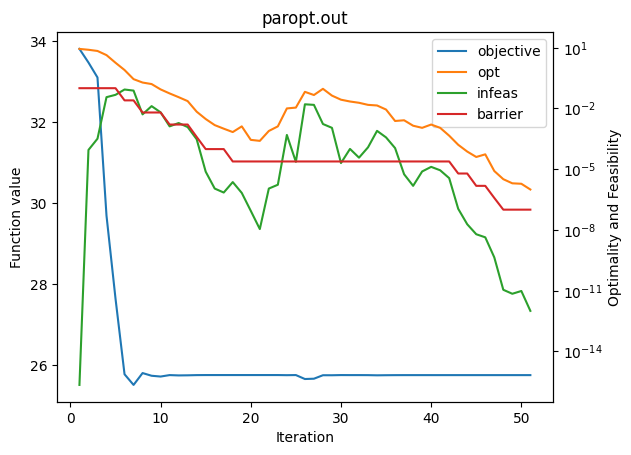

In [2]:
from paropt import ParOpt, plot_history
import mpi4py.MPI as MPI
import numpy as np
import matplotlib.pylab as plt


class Electron(ParOpt.Problem):
    def __init__(self, n, epsilon):
        # Set the communicator pointer
        self.comm = MPI.COMM_WORLD
        self.n = n
        self.nvars = 3 * n
        self.num_sparse_constraints = n
        self.epsilon = epsilon

        rowp = [0]
        cols = []
        for i in range(self.n):
            cols.extend([i, n + i, 2 * n + i])
            rowp.append(len(cols))

        # Initialize the base class
        super(Electron, self).__init__(
            self.comm,
            nvars=self.nvars,
            num_sparse_constraints=self.num_sparse_constraints,
            num_sparse_inequalities=0,
            rowp=rowp,
            cols=cols,
        )

        return

    def getVarsAndBounds(self, x, lb, ub):
        """Set the values of the bounds"""
        n = self.n

        # x = [x_1, ..., x_n, y_1, ..., y_n, z_1, ..., z_n]
        np.random.seed(0)
        alpha = np.random.uniform(low=0.0, high=2 * np.pi, size=n)
        beta = np.random.uniform(low=-np.pi, high=np.pi, size=n)
        for i in range(n):
            x[i] = np.cos(beta[i]) * np.cos(alpha[i])
            x[n + i] = np.cos(beta[i]) * np.sin(alpha[i])
            x[2 * n + i] = np.sin(beta[i])

        lb[:] = -10.0
        ub[:] = 10.0

        return

    def evalSparseObjCon(self, x, sparse_cons):
        """Evaluate the objective and constraint"""
        n = self.n
        epsilon = self.epsilon
        _x = x[:n]
        _y = x[n : 2 * n]
        _z = x[2 * n :]

        fobj = 0.0
        for i in range(n - 2):
            for j in range(i + 1, n - 1):
                dsq = (_x[i] - _x[j]) ** 2 + (_y[i] - _y[j]) ** 2 + (_z[i] - _z[j]) ** 2
                if dsq < epsilon:
                    dsq = epsilon
                fobj += dsq ** (-1 / 2)

        for i in range(n):
            sparse_cons[i] = 1.0 - (_x[i] ** 2 + _y[i] ** 2 + _z[i] ** 2)

        con = []
        fail = 0

        return fail, fobj, con

    def evalSparseObjConGradient(self, x, g, A, data):
        """Evaluate the objective and constraint gradient"""
        n = self.n
        epsilon = self.epsilon
        _x = x[:n]
        _y = x[n : 2 * n]
        _z = x[2 * n :]

        g[:] = 0.0
        for i in range(n - 2):
            for j in range(i + 1, n - 1):
                dsq = (_x[i] - _x[j]) ** 2 + (_y[i] - _y[j]) ** 2 + (_z[i] - _z[j]) ** 2
                if dsq < epsilon:
                    dsq = epsilon
                else:
                    fact = dsq ** (-3 / 2)
                    g[i] += -(_x[i] - _x[j]) * fact
                    g[j] += (_x[i] - _x[j]) * fact
                    g[n + i] += -(_y[i] - _y[j]) * fact
                    g[n + j] += (_y[i] - _y[j]) * fact
                    g[2 * n + i] += -(_z[i] - _z[j]) * fact
                    g[2 * n + j] += (_z[i] - _z[j]) * fact

        for i in range(n):
            data[3 * i] = -2.0 * _x[i]
            data[3 * i + 1] = -2.0 * _y[i]
            data[3 * i + 2] = -2.0 * _z[i]

        fail = 0

        return fail

# use interior point algorithm
options = {
    "algorithm": "ip",
    "norm_type": "infinity",
    "qn_type": "bfgs",
    "qn_subspace_size": 10,
    "starting_point_strategy": "least_squares_multipliers",
    "qn_update_type": "damped_update",
    "abs_res_tol": 1e-6,
    "barrier_strategy": "monotone",
    "armijo_constant": 1e-5,
    "penalty_gamma": 100.0,
    "max_major_iters": 500,
}

n = 10
problem = Electron(n, 1e-15)
# It is a good idea to check gradients, but this call doesn't work for the moment for sparse constraints
# problem.checkGradients()
opt = ParOpt.Optimizer(problem, options)
opt.optimize()

plot_history("paropt.out")